# 1. PPI and GDA data gathering and interactome reconstruction

## 1.1.
Download PPIs from BioGRID latest release to build the human interactome:

* use “all organisms” tab3 file, unzip and get “Homo sapiens” only
* filter out all non-human interactions, i.e., both “organism A” and “B” fields must be = 9606 (Homo sapiens)
* keep only “physical” interactions” (“Experimental System Type” = physical)
* purge out redundant and self loops
* isolate the largest connected component (LCC)

In [1]:
import os
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import requests
from dotenv import load_dotenv

Load the environment variables from the `.env` file. If you don't have an `.env` file, create one and place the API token for DisGenet inside. 

```
disgenet_api_token="<api token>"
```

In [2]:
load_dotenv()

True

If you haven't already, download the biogrid data, unzip it and place the homo sapiens txt file inside the `data/` directory.

In [3]:
!wget -O biogrid.zip https://downloads.thebiogrid.org/Download/BioGRID/Latest-Release/BIOGRID-ORGANISM-LATEST.tab3.zip

--2024-01-12 10:04:08--  https://downloads.thebiogrid.org/Download/BioGRID/Latest-Release/BIOGRID-ORGANISM-LATEST.tab3.zip
Resolving downloads.thebiogrid.org (downloads.thebiogrid.org)... 173.255.198.187
Connecting to downloads.thebiogrid.org (downloads.thebiogrid.org)|173.255.198.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/download]
Saving to: ‘biogrid.zip’

biogrid.zip             [             <=>    ] 160.74M  5.70MB/s    in 31s     

2024-01-12 10:04:42 (5.18 MB/s) - ‘biogrid.zip’ saved [168552342]



Then, let's extract the homo sapiens file into the `data/` directory.

In [4]:
data_folder = "data"
Path(data_folder).mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile("biogrid.zip", 'r') as zip_ref:
        # Iterate through the files in the zip archive
        for file_info in zip_ref.infolist():
            # Check if the file name matches the target filename
            if "Homo_sapiens" in file_info.filename:
                # Extract the file to the target folder
                zip_ref.extract(file_info, data_folder)
                
                # rename the file
                os.rename(os.path.join(data_folder, file_info.filename), os.path.join(data_folder, "biogrid.txt"))
                break

Let's load the file, it is **tab separated** so we need to specify the tab separator `\t`. Also, some of the columns have mixed data types, so we set `low_memory=False`.

In [5]:
biogrid = pd.read_csv("data/biogrid.txt", sep="\t", low_memory=False)

For an explanation of the different columns, we can check the [biogrid wiki](https://wiki.thebiogrid.org/doku.php/biogrid_tab_version_3.0).

In [89]:
biogrid

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188614,3590145,253260,7408,128962,113251,-,-,RICTOR,VASP,AVO3|PIA|hAVO3,...,A0A024R0V4,NP_003361,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1188615,3590146,253260,1072,128962,107499,-,-,RICTOR,CFL1,AVO3|PIA|hAVO3,...,V9HWI5,NP_005498,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1188616,3590147,7189,4217,113041,110381,-,RP3-325F22.4,TRAF6,MAP3K5,MGC:3310|RNF85,...,-,NP_005914,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1188617,3621586,8237,1956,113866,108276,RP4-659F15.2,-,USP11,EGFR,UHX1,...,-,NP_001333829|NP_001333828|NP_958440|NP_005219|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens


### Filter out all non-human interactions, i.e., both “organism A” and “B” fields must be = 9606 (Homo sapiens)
First, we only keep human PPIs. The organism A and B columns are columns `Organism ID Interactor A` and `Organism ID Interactor B`.

In [6]:
biogrid_human = biogrid[(biogrid["Organism ID Interactor A"] == 9606) & (biogrid["Organism ID Interactor B"] == 9606)]

### Keep only “physical” interactions” (“Experimental System Type” = physical)
Then, let's remove all non-physical interactions.

In [7]:
biogrid_human_physical = biogrid_human[biogrid_human["Experimental System Type"] == "physical"]

### Purge out redundant and self loops
Some of PPIs could be between proteins and themselves. If we think of the interactions as a graph structure, any edge that refers to its origin node can be removed. We can also remove any duplicate edges between nodes.

First, let's remove the self-loops by checking where the **Offical Symbol Interactor** columns are the same.

In [8]:
biogrid_no_self_loops = biogrid_human_physical[biogrid_human_physical["Official Symbol Interactor A"] != biogrid_human_physical["Official Symbol Interactor B"]]

print(f"Total number of self loops {len(biogrid_human_physical) - len(biogrid_no_self_loops)}")

Total number of self loops 7393


As a next step, let's also remove all duplicate rows for the **Official Symbol Interactor A/B**, since we want to build a **simple** graph out of these interactors and not a **multi-graph**.

In [9]:
biogrid_no_duplicates = biogrid_no_self_loops[~biogrid_no_self_loops[["Official Symbol Interactor A", "Official Symbol Interactor B"]].duplicated()]

print(f"There are {len(biogrid_no_self_loops) - len(biogrid_no_duplicates)} duplicate rows")

There are 219740 duplicate rows


### Isolate LCC
Finally, let's find the largest connected component (LCC) in the graph. The LCC is the largest subgraph that exists in our network. In this subgraph, every node can be reached from every other node.

In [10]:
ppi_graph = nx.Graph()
ppi_graph.add_edges_from(zip(biogrid_no_duplicates["Entrez Gene Interactor A"], biogrid_no_duplicates["Entrez Gene Interactor B"]))

We can use the `connected_components` function from networkx to give us the nodes of the largest connected component. Then, we create a subgraph of these components.

In [11]:
ppi_lcc_nodes = max(nx.connected_components(ppi_graph), key=len)
ppi_lcc = ppi_graph.subgraph(ppi_lcc_nodes).copy()

### Save Network File
For point 2, we need the LCC of the PPI network. We use the Entrez IDs because the disease data that we fetch later maps to this ID type.

In [12]:
nx.to_pandas_edgelist(ppi_lcc).to_csv("ppi_lcc.txt", index=False, header=False)

## 1.2 Gather gene-disease associations
We want to gather gene-disease associations to explore the links between genes associated with specific diseases and the proteins they interact with.

I will use the DisGENET REST-API to fetch the cureated information associated with the **polydactyly** disease (C0152427). Since the API requirest an authentication token, we will load the one we got when we created our account there from an environment variable.

In [13]:
polydactyly_concept_id = "C0152427"

In [14]:
response = requests.get(f"https://www.disgenet.org/api/gda/disease/{polydactyly_concept_id}", 
             params={"source":"CURATED"},
             headers={'Authorization': f'Bearer {os.getenv("disgenet_api_token")}'})

Let's take the response and turn it into a pandas dataframe to be able to work with it. The columns in the dataframe have the following meaning:

* geneId: NCBI Entrez Gene Identifier
* geneSymbol: Official Gene Symbol
* DSI: The Disease Specificity Index for the gene
* DPI: The Disease Pleiotropy Index for the gene
* PLI: The probability for the gene of being loss-of-function intolerant, provided by the GNOMAD consortium
* protein_class: Protein Class identifier according to the Drug Target Ontology  
* protein_class_name: Protein Class according to the Drug Target Ontology  
* NofDiseases: Number of diseases associated to the gene
* NofPmids: Number of publications associated to the gene

[source](https://www.disgenet.org/static/disgenet_ap1/files/downloads/readme.txt)


In [15]:
disease_df = pd.DataFrame(response.json())
disease_df.geneid = disease_df.geneid.astype(str)

### Keep Seed Genes in Interactome
We only want to keep the seed genes that are actually present in the PPI interactome.

In [16]:
disease_df_in_ppi = disease_df[disease_df.geneid.isin(biogrid_no_duplicates["Entrez Gene Interactor A"]) & disease_df.geneid.isin(biogrid_no_duplicates["Entrez Gene Interactor B"])]

### Save Seed Genes
As for the PPIs above, we need to save the disease genes as a `.txt` file. We only save the `geneid` because that is the only data we need to run the algorithms for point 2.

In [17]:
disease_df_in_ppi.geneid.to_csv("seed_genes.txt", index=False, header=False)

## 1.3 Compute and characterize the disease LCC and its basic network measures
We need to do the following:

* isolate the LCC of the disease network
* Summarize the GDA-related data
* Compute the following network metrics on the disease LCC:
    * Node degree
    * Betweenness centrality
    * Eigenvector centrality
    * Closeness centrality
    * ratio Betweenness/Node degree
* Report in a table the above network measures of the first 50 disease genes
in the disease LCC ordered for node degree from higher to lower
* Represent node degree and node betweenness in a scatterplot

### Isolate LCC of the Disease Network
Here we want to **overlap** the genes from GDA with the genes in PPI, using the Entrez Gene ID. First, let's select the PPIs that have Entrez Interactors in the polydactyly gene disease association data frame.

In [18]:
# the PPIs that appear in the GDA
disease_genes = biogrid_no_duplicates[(biogrid_no_duplicates["Entrez Gene Interactor A"].isin(disease_df.geneid)) & (biogrid_no_duplicates["Entrez Gene Interactor B"].isin(disease_df.geneid))]

In [19]:
disease_genes

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
26281,286709,79659,51626,122785,119644,-,CGI-60,DYNC2H1,DYNC2LI1,ATD3|DHC1b|DHC2|DNCH2|DYH1B|SRPS2B|SRTD3|hdhc11,...,-,NP_056337|NP_057092|NP_001180393,-,-,-,-,-,-,Homo sapiens,Homo sapiens
26282,286710,51626,79659,119644,122785,CGI-60,-,DYNC2LI1,DYNC2H1,D2LIC|LIC3,...,-,NP_001073932|NP_001368,-,-,-,-,-,-,Homo sapiens,Homo sapiens
31663,303378,2263,2255,108554,108546,-,-,FGFR2,FGF10,BBDS|BEK|BFR-1|CD332|CEK3|CFD1|ECT1|JWS|K-SAM|...,...,-,NP_004456,-,-,-,-,-,-,Homo sapiens,Homo sapiens
108651,719956,4750,11127,110825,116300,-,-,NEK1,KIF3A,NY-REN-55|SRPS2|SRPS2A|SRTD6,...,E9PES4|J3KPF9|Q05CT3|B4DHG8,NP_008985|NP_001287720|NP_001287721,-,-,-,-,-,-,Homo sapiens,Homo sapiens
113324,726261,5296,5290,111314,111308,-,-,PIK3R2,PIK3CA,MPPH|MPPH1|P85B|p85|p85-BETA,...,-,NP_006209,BTO:0000664,K-562 cell,cell line,DOID:8552,chronic myeloid leukemia,-,Homo sapiens,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119584,3490560,2260,2263,108551,108554,-,-,FGFR1,FGFR2,BFGFR|CD331|CEK|FGFBR|FGFR-1|FLG|FLT-2|FLT2|HB...,...,D3DRD5|D2CGD1,NP_000132|NP_075259|NP_075418|NP_001138389|NP_...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1131155,3509017,2263,5296,108554,111314,-,-,FGFR2,PIK3R2,BBDS|BEK|BFR-1|CD332|CEK3|CFD1|ECT1|JWS|K-SAM|...,...,-,NP_005018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1131778,3509640,2261,2260,108552,108551,-,-,FGFR3,FGFR1,ACH|CD333|CEK2|HSFGFR3EX|JTK4,...,-,NP_075598|NP_075593|NP_075594|NP_001167538|NP_...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1132261,3510123,2261,8239,108552,113867,-,RP5-1172N10.4,FGFR3,USP9X,ACH|CD333|CEK2|HSFGFR3EX|JTK4,...,Q6P468|Q86X58,NP_001034680|NP_001034679,-,-,-,-,-,-,Homo sapiens,Homo sapiens


Then, let's first create a graph from the PPIs that are associated with Polydactyly.

In [20]:
disease_ppi_graph = nx.Graph()
disease_ppi_graph.add_edges_from(zip(disease_genes["Official Symbol Interactor A"], disease_genes["Official Symbol Interactor B"]))

Once we have the graph of the PPIs that are associated with Polydactyly, we can select the subgraph that has the most connected components.

In [21]:
disease_ppi_lcc_nodes = max(nx.connected_components(disease_ppi_graph), key=len)
disease_ppi_lcc = disease_ppi_graph.subgraph(disease_ppi_lcc_nodes).copy()

### Summarise the GDA Related Data
Here, we summarise the GDA data in a table.

In [23]:
disease_name = "Polydactyly"
disease_id = polydactyly_concept_id
disease_class = "C05"
num_associated_genes = len(disease_df)
num_genes_in_interactome = disease_ppi_graph.number_of_nodes()
lcc_interactome_size = disease_ppi_lcc.number_of_nodes()

In [24]:
gda_summary_df = pd.DataFrame(data=[[disease_name, disease_id, disease_class, num_associated_genes, num_genes_in_interactome, lcc_interactome_size]], columns=["Disease Name", "UMLS Disease ID", "MeSH Disease Class", "Number of Associated Genes", "Number of Genes Present in Interactome", "LCC Size of the Disease Interactome"])
gda_summary_df.to_csv("gda_summary_df.csv", index=None)
display(gda_summary_df)

,Disease Name,UMLS Disease ID,MeSH Disease Class,Number of Associated Genes,Number of Genes Present in Interactome,LCC Size of the Disease Interactome
0,Polydactyly,C0152427,C05,117,78,63


### Network Metrics
Now, let's summarise the network metrics for the first 50 disease genes in the disease LCC ordered for node degree in descending order.

First, we gather all the metrics on the entire graph using `networkx`, we can do this because it is a small graph. 

In [25]:
degrees = {node: nx.degree(disease_ppi_lcc, node) for  node in disease_ppi_lcc}
betweenness_centralities = nx.betweenness_centrality(disease_ppi_lcc)
eigenvector_centralities = nx.eigenvector_centrality(disease_ppi_lcc)
closeness_centralities = nx.closeness_centrality(disease_ppi_lcc)

As the next step, let's rework the data so that we can create a nice pandas dataframe out of it. We will create a list of lists, where each nested list is a **row** in the dataframe.

```
[[gene, degree, betweenness, eigenvector, closeness, ratio]]
```

In [26]:
rows = []
for node in disease_ppi_lcc:
    degree = degrees[node]
    betweenness = betweenness_centralities[node]
    eigenvector = eigenvector_centralities[node]
    closeness = closeness_centralities[node]
    ratio = betweenness / degree
    
    rows.append([node, degree, betweenness, eigenvector, closeness, ratio])

Finally, we create the dataframe using the list of lists created in the cell above, save it, sort it, and display the first 50 rows.

In [29]:
column_names = ["Gene", "Degree", "Betweenness Centrality", "Eigenvector Centrality", "Closeness Centrality", "Betweenness Degree Ratio"]

network_summary_df = pd.DataFrame(rows, columns=column_names)
network_summary_df.sort_values("Degree", ascending=False, inplace=True)
network_summary_df["Rank"] = range(1, len(network_summary_df) + 1)

# round to the 4th decimal to make the table fit the page width in the report
network_summary_df[network_summary_df.select_dtypes("float64").columns] = network_summary_df.select_dtypes('float64').round(4)

# rearrange columns to put rank first as demanded by the instructions
columns = network_summary_df.columns.tolist()
network_summary_df = network_summary_df[[columns[-1]] + columns[:-1]]

network_summary_df.to_csv("network_metrics.csv", index=None)
display(network_summary_df.head(50))

,Rank,Gene,Degree,Betweenness Centrality,Eigenvector Centrality,Closeness Centrality,Betweenness Degree Ratio
12,1,BBS7,11,0.1712,0.3668,0.3039,0.0156
26,2,OFD1,10,0.5001,0.0802,0.3974,0.0500
10,3,BBS4,9,0.2526,0.3565,0.3388,0.0281
17,4,TCTN2,9,0.1036,0.0101,0.2884,0.0115
27,5,CC2D2A,9,0.2979,0.0242,0.3563,0.0331
13,6,BBS1,9,0.1243,0.3519,0.2870,0.0138
8,7,LZTFL1,8,0.0323,0.3455,0.2831,0.0040
15,8,BBS5,7,0.0000,0.3396,0.2818,0.0000
14,9,BBS9,7,0.0000,0.3396,0.2818,0.0000
24,10,IFT88,7,0.1789,0.0118,0.2696,0.0256


### Represent node degree and node betweenness in a scatterplot
Let's plot the node betweenness as a function of the node degree. From the plot we can perhaps see a small trend where the betweenness centrality increases with the degree of a node. A high betweenness centrality for a node means that many shortest paths in the network are crossing through this node. This, in turn, means that a lot of information flows through the node in question and that it is great influence on interactions between node pairs in the network. From the plot we can see that the higher the degree of a node, the more information flows through it.

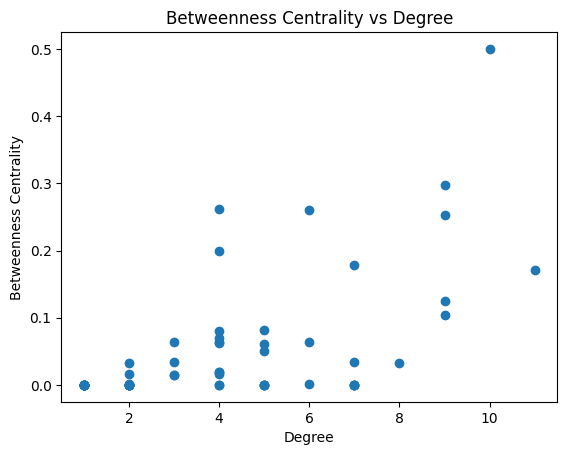

In [31]:
plt.scatter(network_summary_df["Degree"], network_summary_df["Betweenness Centrality"])
plt.xlabel("Degree")
plt.ylabel("Betweenness Centrality")
plt.title("Betweenness Centrality vs Degree")
plt.savefig("betweenness_centrality_vs_degree.pdf", format="pdf")